# Evaluating n-grams across a select number of post translational modification systems

Many reversible post translational modification (PTM) systems operate within a reader-writer-eraser paradigm at the domain level. Many proteins in these systems are multi-domain and in a survey of the domain architectures of the phosphotyrosine system, recurrent patterns can be observed. Whether n-gram analysis can provide insights into the interplay between domain architecture evolution and protein functionality has not been widely explored.

## Note: For this notebook, we highly recommend using the separate dansy_codiac environment. 

There are some different versions for common package dependencies (e.g. numpy) between DANSy and CoDIAC, which should not impact any of the analysis, but as a precaution recommend using that specific kernel to ensure no unexpected behavior occurs in other notebooks.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import ngramUtilities
import matplotlib.pyplot as plt
import entropyCalc
import ngramNets

ModuleNotFoundError: No module named 'networkx'

In [2]:
import generateCompleteProteome
from CoDIAC import InterPro
import CoDIAC

In [3]:
# Setting the random seed to be reproducible
import random
random.seed(1)
np.random.seed(1)

In [4]:
def retrieve_uniprot_ids_OI(id_list):
    '''
    Retrieves the UniProt IDs using CoDIAC for the PTM systems of interest. The InterPro IDs of the domains should be provided.
    '''

    ptm_sys_ids = set()
    for id in id_list:
        ptm_temp,_ = CoDIAC.InterPro.fetch_uniprotids(id)
        ptm_sys_ids.update(ptm_temp)
    return ptm_sys_ids

def expand_dict(d):
    '''
    Expands a dictionary that has multiple elements per key and the key-value pairs as a result.
    '''

    v_list = []
    k_list = []
    for (k,v) in d.items():
        v_list += v
        dup_k = [k]*len(v)
        k_list += dup_k
    expanded_d = dict(zip(v_list, k_list))

    return expanded_d

def draw_ngram_network(orig_G, dom_cats = None, cat_colors = None):

    if dom_cats == None:
        dom_cats = {}

    if cat_colors == None:
        cat_colors = {}
    G = orig_G.copy()
    G.remove_edges_from(nx.selfloop_edges(G))
    for node in G.nodes():
        col = '#d3d3d3'
        for domain, type in dom_cats.items():
            if domain in node:
                col = cat_colors[type]
        
        nx.set_node_attributes(G, values={node:{'color':col}})
    
    return G

In [ ]:
def generate_ngram_summary(uniprot_ids,full_ref, interpro_dict, color_cats):

    reader_dom = interpro_dict['Reader']
    writer_dom = interpro_dict['Writer']
    eraser_dom = interpro_dict['Eraser']
    all_Interpro_IDs = interpro_dict['Full List']

    base_dansy = ngramNets.dansy(uniprot_ids, ref=full_ref, interproIDs=all_Interpro_IDs, n=66)
    
    p_seeded = entropyCalc.build_freq_dict_from_adj(base_dansy.adj, base_dansy.ref['Interpro Domain Architecture IDs'],base_dansy.collapsed_ngrams)
    interpro_conv = base_dansy.interpro_conversion
    # Creating dictionary of general categories and domain members (can change as needed)
    domain_categories = {'Reader':reader_dom, 
                        'Writer':writer_dom,
                        'Eraser':eraser_dom}
    
    domain_categories = expand_dict(domain_categories)

    G_seeded = draw_ngram_network(base_dansy.G,domain_categories, color_cats)
    ccs = [nx.number_connected_components(G_seeded)]
    isols = [nx.number_of_isolates(G_seeded)]

    base_dansy = ngramNets.dansy(uniprot_ids, ref=full_ref, n=66)
    p = entropyCalc.build_freq_dict_from_adj(base_dansy.adj, base_dansy.ref['Interpro Domain Architecture IDs'],base_dansy.collapsed_ngrams)
    ce = entropyCalc.relativeEntropy(p_seeded, p)
    
    G = draw_ngram_network(base_dansy.G,domain_categories, color_cats)
    ccs.append(nx.number_connected_components(G))
    isols.append(nx.number_of_isolates(G))
    x = [ccs ,isols,ce]
    G_nets = [G, G_seeded]
    return x, G_nets

In [6]:
# Importing the reference files for the complete proteome that will then be reduced to the PTM systems of interest
full_ref,full_interpro_dict = generateCompleteProteome.import_proteome_files()

In [7]:
# Aggregate Results
full_ID_list = []
full_ref_list = []
full_reader_list = []
full_eraser_list = []
full_writer_list = []

# Coloring options
writer = '#22c919' #orange
eraser = '#c019c9' #purple
reader = '#f2b120' #green
color_cats = {'Reader':reader, 'Writer':writer, 'Eraser':eraser}

## Starting with the phosphotyrosine system

In [8]:
ptyr_sys = ['IPR020635','IPR000242','IPR000980','IPR006020']
ptyr_unis = retrieve_uniprot_ids_OI(ptyr_sys)

Fetched 79 Uniprot IDs linked to IPR020635, where count expected to be 79
Fetched 38 Uniprot IDs linked to IPR000242, where count expected to be 38
Fetched 109 Uniprot IDs linked to IPR000980, where count expected to be 109
Fetched 41 Uniprot IDs linked to IPR006020, where count expected to be 41


In [9]:
ptyr_ref = full_ref[full_ref['UniProt ID'].isin(ptyr_unis)]

In [10]:
# Writers
Interpro_ID_ProtKinase = 'IPR000719' #IPR020635 is the actual domain
writer_dom = [Interpro_ID_ProtKinase]

#Erasers
Interpro_ID_PTP = 'IPR000242'
eraser_dom = [Interpro_ID_PTP]

# Readers
Interpro_ID_SH2= 'IPR000980'
Interpro_ID_PTB = 'IPR006020'
reader_dom = [Interpro_ID_SH2,Interpro_ID_PTB]

In [11]:
all_Interpro_IDs = [Interpro_ID_ProtKinase,Interpro_ID_PTP,Interpro_ID_SH2,Interpro_ID_PTB]
full_ID_list.append(all_Interpro_IDs)
full_reader_list.append(reader_dom)
full_eraser_list.append(eraser_dom)
full_writer_list.append(writer_dom)

In [12]:
tyr_interpro = {'Reader':reader_dom, 'Writer':writer_dom,'Eraser':eraser_dom,'Full List':all_Interpro_IDs}
ptm_net_info,pTyr_Gs = generate_ngram_summary(ptyr_unis,full_ref,tyr_interpro, color_cats)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


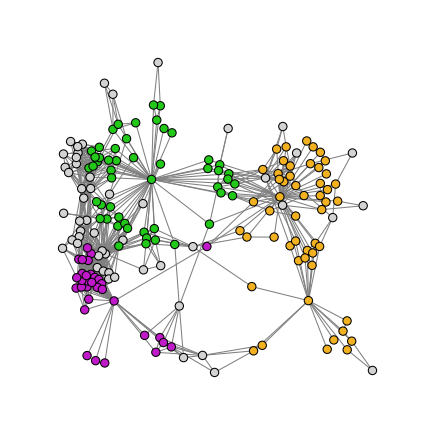

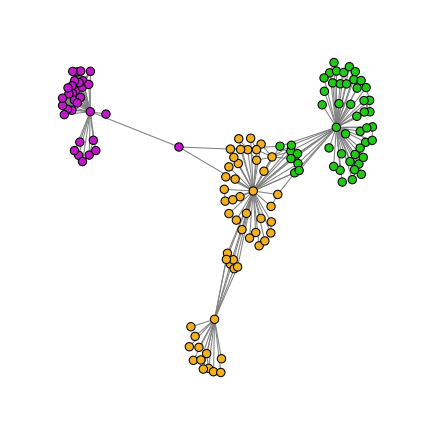

In [13]:
net_type = ['Full','Seeded']
for idx,G in enumerate(pTyr_Gs):
        plt.figure(figsize=(1.25,1.25), dpi = 300)
        node_attribs = dict(G.nodes(data=True))
        pos = nx.nx_agraph.pygraphviz_layout(G,prog='sfdp')
        nx.draw(G, pos=pos, 
                node_color=[v['color'] for v in node_attribs.values()], 
                node_size = 4, 
                edgecolors= 'k',
                font_size=6, edge_color = '#808080', width = 0.25, linewidths = 0.25)
        plt.savefig(f'Figures/Manuscript Figures/Figure 4 PTM System Analysis/pY {net_type[idx]} System.svg', transparent=True)

In [14]:
# Generate a dataframe of connected components for each PTM for a summary graph.
ptm_nNet_summary = pd.DataFrame(index=['pY','pST','M','A','U','All'], columns = ['CC','Isolates','CC Full','Isolates Full', 'Relative Entropy'])
ptm_nNet_summary.loc['pY','CC'] = ptm_net_info[0][0]
ptm_nNet_summary.loc['pY','Isolates'] = ptm_net_info[1][0]

# Adding in the number of connected components in the full ngram network
ptm_nNet_summary.loc['pY','CC Full'] = ptm_net_info[0][1]
ptm_nNet_summary.loc['pY','Isolates Full'] = ptm_net_info[1][1]

# Relative entropy
ptm_nNet_summary.loc['pY','Relative Entropy'] = ptm_net_info[2]

# The phosphoserine/threonine system

In [15]:
# Importing the reader-writer-eraser system of interest

# Writer
Interpro_ID_ProtKinase = 'IPR000719' #IPR001245 is the actual domain ID with ...719 being the protein kinase family
writer_dom = [Interpro_ID_ProtKinase]

# Eraser
Interpro_ID_PhosP = 'IPR004843' # Note IPR006186 is the phosphatase domain's actual ID but it is a child of the calcineurin one
Interpro_ID_PPM = 'IPR001932'
Interpro_ID_FCP= 'IPR004274'
eraser_dom = [Interpro_ID_PhosP, Interpro_ID_PPM,Interpro_ID_FCP]

# Reader domains
Interpro_ID_WW = 'IPR001202'

Interpro_ID_1433 = 'IPR023410'


Interpro_ID_FHA = 'IPR000253'


Interpro_ID_MH2 = 'IPR001132'


Interpro_ID_BRCT = 'IPR001357'


Interpro_ID_FF = 'IPR002713'
reader_dom = [Interpro_ID_WW,Interpro_ID_1433,Interpro_ID_FHA,Interpro_ID_MH2, Interpro_ID_BRCT,Interpro_ID_FF]

In [16]:

all_Interpro_IDs = [Interpro_ID_ProtKinase, Interpro_ID_PhosP,Interpro_ID_PPM,Interpro_ID_FCP, Interpro_ID_WW, Interpro_ID_1433, Interpro_ID_FHA, Interpro_ID_MH2,Interpro_ID_BRCT,Interpro_ID_FF]

full_ID_list.append(all_Interpro_IDs)
full_reader_list.append(reader_dom)
full_eraser_list.append(eraser_dom)
full_writer_list.append(writer_dom)

In [17]:
pST_interpro = ['IPR001245', 'IPR006186',Interpro_ID_PPM,Interpro_ID_FCP, Interpro_ID_WW, Interpro_ID_1433, Interpro_ID_FHA, Interpro_ID_MH2,Interpro_ID_BRCT,Interpro_ID_FF]

In [18]:
pst_ids = retrieve_uniprot_ids_OI(pST_interpro)

Fetched 128 Uniprot IDs linked to IPR001245, where count expected to be 128
Fetched 13 Uniprot IDs linked to IPR006186, where count expected to be 13
Fetched 20 Uniprot IDs linked to IPR001932, where count expected to be 20
Fetched 8 Uniprot IDs linked to IPR004274, where count expected to be 8
Fetched 52 Uniprot IDs linked to IPR001202, where count expected to be 52
Fetched 7 Uniprot IDs linked to IPR023410, where count expected to be 7
Fetched 33 Uniprot IDs linked to IPR000253, where count expected to be 33
Fetched 8 Uniprot IDs linked to IPR001132, where count expected to be 8
Fetched 24 Uniprot IDs linked to IPR001357, where count expected to be 24
Fetched 6 Uniprot IDs linked to IPR002713, where count expected to be 6


In [19]:
tyrKin_ids = retrieve_uniprot_ids_OI(['IPR020635'])

Fetched 79 Uniprot IDs linked to IPR020635, where count expected to be 79


In [20]:
pst_ids = pst_ids.difference(tyrKin_ids)
st_interpro = {'Reader':reader_dom, 'Writer':writer_dom,'Eraser':eraser_dom,'Full List':all_Interpro_IDs}
ptm_net_info,pST_Gs = generate_ngram_summary(pst_ids,full_ref,st_interpro, color_cats)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


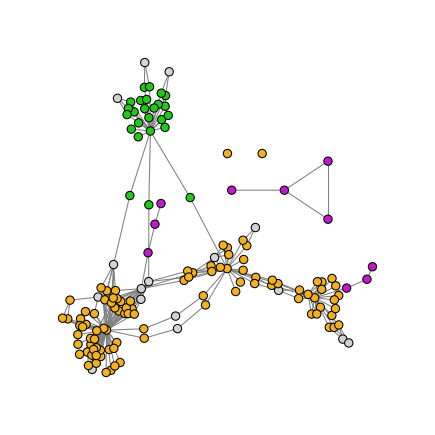

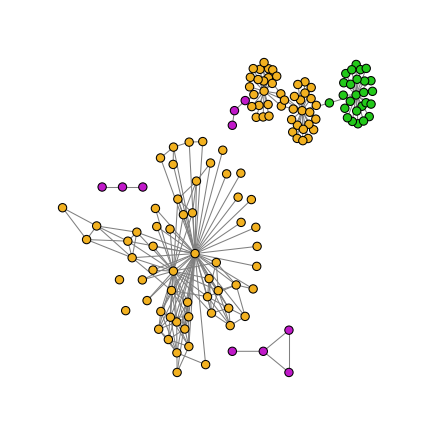

In [21]:
for idx,G in enumerate(pST_Gs):
        plt.figure(figsize=(1.25,1.25), dpi = 300)
        node_attribs = dict(G.nodes(data=True))
        pos = nx.nx_agraph.pygraphviz_layout(G,prog='sfdp')
        nx.draw(G, pos=pos, 
                node_color=[v['color'] for v in node_attribs.values()], 
                node_size = 4, 
                edgecolors= 'k',
                edge_color = '#808080', width = 0.25, linewidths = 0.25)
        plt.savefig(f'Figures/Manuscript Figures/Figure 4 PTM System Analysis/pST {net_type[idx]} System.svg', transparent=True)

In [22]:
# Adding in the number of connected components in the full ngram network
ptm_nNet_summary.loc['pST','CC'] = ptm_net_info[0][0]
ptm_nNet_summary.loc['pST','Isolates'] = ptm_net_info[1][0]
ptm_nNet_summary.loc['pST','CC Full'] = ptm_net_info[0][1]
ptm_nNet_summary.loc['pST','Isolates Full'] = ptm_net_info[1][1]


# Relative entropy
ptm_nNet_summary.loc['pST','Relative Entropy'] = ptm_net_info[2]

# Acetylation

In [23]:
# Writers (lots of these)
Interpro_ID_MSYT = 'IPR002717'
Interpro_ID_CBP = 'IPR031162'
Interpro_ID_TAF1 = 'IPR022591'
Interpro_ID_GNAT = 'IPR000182'
writer_dom = [Interpro_ID_MSYT, Interpro_ID_CBP, Interpro_ID_TAF1, Interpro_ID_GNAT]

# Erasers
Interpro_ID_HDAC = 'IPR023801'
Interpro_ID_SIRT = 'IPR026590'
eraser_dom = [Interpro_ID_HDAC,Interpro_ID_SIRT]

# Reader
Interpro_ID_Bromo = 'IPR001487'
reader_dom = [Interpro_ID_Bromo]

In [24]:
all_Interpro_IDs = [Interpro_ID_MSYT, Interpro_ID_CBP,Interpro_ID_TAF1,Interpro_ID_GNAT,Interpro_ID_HDAC,Interpro_ID_SIRT,Interpro_ID_Bromo]

full_ID_list.append(all_Interpro_IDs)

full_reader_list.append(reader_dom)
full_eraser_list.append(eraser_dom)
full_writer_list.append(writer_dom)

In [25]:
acetyl_ids = retrieve_uniprot_ids_OI(all_Interpro_IDs)

Fetched 5 Uniprot IDs linked to IPR002717, where count expected to be 5
Fetched 2 Uniprot IDs linked to IPR031162, where count expected to be 2
Fetched 2 Uniprot IDs linked to IPR022591, where count expected to be 2
Fetched 25 Uniprot IDs linked to IPR000182, where count expected to be 25
Fetched 11 Uniprot IDs linked to IPR023801, where count expected to be 11
Fetched 7 Uniprot IDs linked to IPR026590, where count expected to be 7
Fetched 42 Uniprot IDs linked to IPR001487, where count expected to be 42


In [26]:
acetyl_interpro = {'Reader':reader_dom, 'Writer':writer_dom,'Eraser':eraser_dom,'Full List':all_Interpro_IDs}
ptm_net_info,AC_Gs = generate_ngram_summary(acetyl_ids,full_ref,acetyl_interpro, color_cats)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


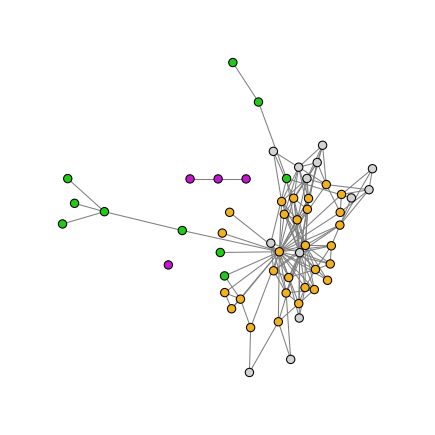

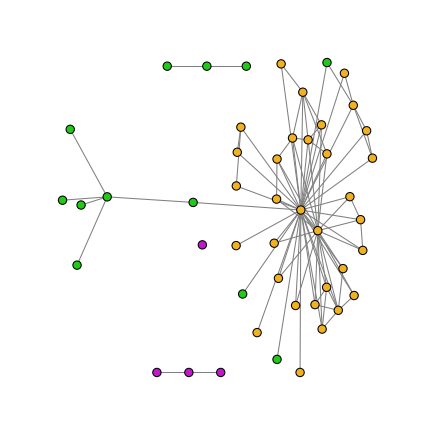

In [27]:
for idx,G in enumerate(AC_Gs):
        plt.figure(figsize=(1.25,1.25), dpi = 300)
        node_attribs = dict(G.nodes(data=True))
        pos = nx.nx_agraph.pygraphviz_layout(G,prog='sfdp')
        nx.draw(G, pos=pos, 
                node_color=[v['color'] for v in node_attribs.values()], 
                node_size = 4, 
                edgecolors= 'k',
                font_size=6, edge_color = '#808080', width = 0.25, linewidths = 0.25)        
        plt.savefig(f'Figures/Manuscript Figures/Figure 4 PTM System Analysis/Acetylation {net_type[idx]} System.svg', transparent=True)

In [28]:
# Adding in the number of connected components in the full ngram network
ptm_nNet_summary.loc['A','CC'] = ptm_net_info[0][0]
ptm_nNet_summary.loc['A','Isolates'] = ptm_net_info[1][0]
ptm_nNet_summary.loc['A','CC Full'] = ptm_net_info[0][1]
ptm_nNet_summary.loc['A','Isolates Full'] = ptm_net_info[1][1]


# Relative entropy
ptm_nNet_summary.loc['A','Relative Entropy'] = ptm_net_info[2]

# Ubiquination

In [29]:
# Importing all the ubiquitin associated system

# Writer system (including the e1 and e2 enzymes not just ligases)

Interpro_ID_hect = 'IPR000569'


Interpro_ID_thif = 'IPR000594'


Interpro_ID_UBQ = 'IPR000608'


writer_dom = [Interpro_ID_hect,Interpro_ID_thif,Interpro_ID_UBQ]

# Readers

Interpro_ID_lz = 'IPR032419'


Interpro_ID_UBA = 'IPR015940'


Interpro_ID_GAT = 'IPR004152'


Interpro_ID_CUE = 'IPR003892'


# These two also have some eraser capabilities it seems but primarily act as readers so will be classified as such
Interpro_ID_znfubz = 'IPR041641'


Interpro_ID_znfUBP = 'IPR001607'


reader_dom = [Interpro_ID_lz,Interpro_ID_UBA,Interpro_ID_GAT,Interpro_ID_CUE, Interpro_ID_znfubz,Interpro_ID_znfUBP]

# These are actual erasers
Interpro_ID_OTU = 'IPR003323'


Interpro_ID_usp = 'IPR028889'
InterproID_U19_UCH = 'IPR001394'


Interpro_ID_jamm = 'IPR000555'


Interpro_ID_josephin = 'IPR006155'


eraser_dom = [Interpro_ID_OTU,Interpro_ID_usp,Interpro_ID_jamm, Interpro_ID_josephin, InterproID_U19_UCH]

In [30]:


all_Interpro_IDs = [Interpro_ID_hect,Interpro_ID_thif,Interpro_ID_UBQ,Interpro_ID_lz,Interpro_ID_UBA,Interpro_ID_GAT,Interpro_ID_CUE,Interpro_ID_znfubz,Interpro_ID_znfUBP, Interpro_ID_OTU,Interpro_ID_jamm,Interpro_ID_usp,InterproID_U19_UCH,Interpro_ID_josephin]

full_ID_list.append(all_Interpro_IDs)
full_reader_list.append(reader_dom)
full_eraser_list.append(eraser_dom)
full_writer_list.append(writer_dom)

In [31]:
ubi_ids = retrieve_uniprot_ids_OI(all_Interpro_IDs)

Fetched 28 Uniprot IDs linked to IPR000569, where count expected to be 28
Fetched 10 Uniprot IDs linked to IPR000594, where count expected to be 10
Fetched 40 Uniprot IDs linked to IPR000608, where count expected to be 40
Fetched 3 Uniprot IDs linked to IPR032419, where count expected to be 3
Fetched 43 Uniprot IDs linked to IPR015940, where count expected to be 43
Fetched 6 Uniprot IDs linked to IPR004152, where count expected to be 6
Fetched 10 Uniprot IDs linked to IPR003892, where count expected to be 10
Fetched 5 Uniprot IDs linked to IPR041641, where count expected to be 5
Fetched 14 Uniprot IDs linked to IPR001607, where count expected to be 14
Fetched 15 Uniprot IDs linked to IPR003323, where count expected to be 15
Fetched 12 Uniprot IDs linked to IPR000555, where count expected to be 12
Fetched 75 Uniprot IDs linked to IPR028889, where count expected to be 75
Fetched 73 Uniprot IDs linked to IPR001394, where count expected to be 73
Fetched 4 Uniprot IDs linked to IPR006155, w

In [32]:
ubi_interpro = {'Reader':reader_dom, 'Writer':writer_dom,'Eraser':eraser_dom,'Full List':all_Interpro_IDs}
ptm_net_info,Ub_Gs = generate_ngram_summary(ubi_ids,full_ref,ubi_interpro, color_cats)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


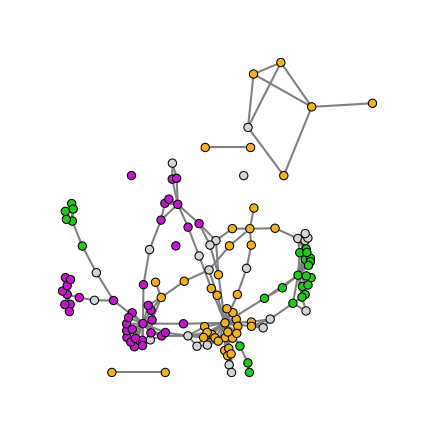

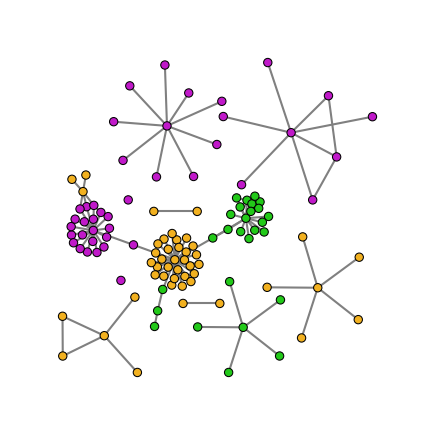

In [33]:
for idx,G in enumerate(Ub_Gs):
        plt.figure(figsize=(1.25,1.25), dpi = 300)
        node_attribs = dict(G.nodes(data=True))
        pos = nx.nx_agraph.pygraphviz_layout(G,prog='sfdp')
        nx.draw(G, pos=pos, 
                node_color=[v['color'] for v in node_attribs.values()], 
                node_size = 4, 
                edgecolors= 'k',
                font_size=6, edge_color = '#808080', width = 0.5, linewidths = 0.25)
        plt.savefig(f'Figures/Manuscript Figures/Figure 4 PTM System Analysis/Ubiquination {net_type[idx]} System.svg', transparent=True)

In [34]:
# Adding in the number of connected components in the full ngram network
ptm_nNet_summary.loc['U','CC'] = ptm_net_info[0][0]
ptm_nNet_summary.loc['U','Isolates'] = ptm_net_info[1][0]
ptm_nNet_summary.loc['U','CC Full'] = ptm_net_info[0][1]
ptm_nNet_summary.loc['U','Isolates Full'] = ptm_net_info[1][1]


# Relative entropy
ptm_nNet_summary.loc['U','Relative Entropy'] = ptm_net_info[2]

# Methylation

In [35]:
# Writers

Interpro_ID_SET = 'IPR001214'


Interpro_ID_DOT = 'IPR025789'


writer_dom = [Interpro_ID_SET, Interpro_ID_DOT]

# Erasers

Interpro_ID_Amino_ox = 'IPR002937'


Interpro_ID_JmjC = 'IPR003347'


eraser_dom = [Interpro_ID_Amino_ox, Interpro_ID_JmjC]

# Readers
Interpro_ID_TUDOR = 'IPR002999'


Interpro_ID_Agenet = 'IPR008395'


Interpro_ID_PWWP = 'IPR000313'


Interpro_ID_Chromo = 'IPR000953' # actual ID 'IPR023780' but larger domain family is the chromo/chromoshadow


reader_dom = [Interpro_ID_TUDOR, Interpro_ID_Agenet, Interpro_ID_PWWP, Interpro_ID_Chromo]

In [36]:
all_Interpro_IDs = [Interpro_ID_SET, Interpro_ID_DOT,Interpro_ID_Amino_ox,Interpro_ID_JmjC,Interpro_ID_TUDOR,Interpro_ID_Agenet,Interpro_ID_PWWP,Interpro_ID_Chromo]

full_ID_list.append(all_Interpro_IDs)
full_reader_list.append(reader_dom)
full_eraser_list.append(eraser_dom)
full_writer_list.append(writer_dom)

In [37]:
meth_ids = retrieve_uniprot_ids_OI(all_Interpro_IDs)

Fetched 52 Uniprot IDs linked to IPR001214, where count expected to be 52
Fetched 1 Uniprot IDs linked to IPR025789, where count expected to be 1
Fetched 10 Uniprot IDs linked to IPR002937, where count expected to be 10
Fetched 33 Uniprot IDs linked to IPR003347, where count expected to be 33
Fetched 29 Uniprot IDs linked to IPR002999, where count expected to be 29
Fetched 3 Uniprot IDs linked to IPR008395, where count expected to be 3
Fetched 22 Uniprot IDs linked to IPR000313, where count expected to be 22
Fetched 30 Uniprot IDs linked to IPR000953, where count expected to be 30


In [38]:
meth_interpro = {'Reader':reader_dom, 'Writer':writer_dom,'Eraser':eraser_dom,'Full List':all_Interpro_IDs}
ptm_net_info,Me_Gs = generate_ngram_summary(meth_ids,full_ref,meth_interpro, color_cats)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


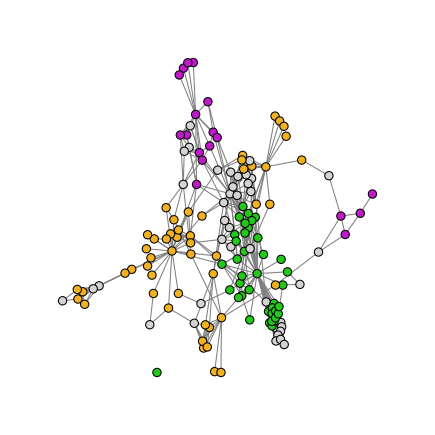

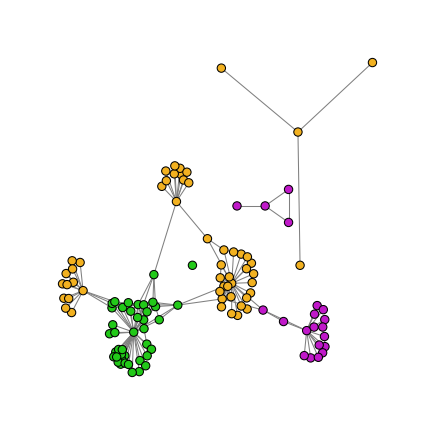

In [39]:
for idx,G in enumerate(Me_Gs):
        plt.figure(figsize=(1.25,1.25), dpi = 300)
        node_attribs = dict(G.nodes(data=True))
        pos = nx.nx_agraph.pygraphviz_layout(G,prog='sfdp')
        nx.draw(G, pos=pos, 
                node_color=[v['color'] for v in node_attribs.values()], 
                node_size = 4, 
                edgecolors= 'k',
                font_size=6, edge_color = '#808080', width = 0.25, linewidths = 0.25)
        plt.savefig(f'Figures/Manuscript Figures/Figure 4 PTM System Analysis/Methylation {net_type[idx]} System.svg', transparent=True)

In [40]:
# Adding in the number of connected components in the full ngram network
ptm_nNet_summary.loc['M','CC'] = ptm_net_info[0][0]
ptm_nNet_summary.loc['M','Isolates'] = ptm_net_info[1][0]
ptm_nNet_summary.loc['M','CC Full'] = ptm_net_info[0][1]
ptm_nNet_summary.loc['M','Isolates Full'] = ptm_net_info[1][1]


# Relative entropy
ptm_nNet_summary.loc['M','Relative Entropy'] = ptm_net_info[2]

# Creating a network consisting of all evaluated PTM systems

In [41]:
full_ID_list = list(set(sum(full_ID_list,[])))
full_eraser_list = list(set(sum(full_eraser_list,[])))
full_writer_list = list(set(sum(full_writer_list,[])))
full_reader_list = list(set(sum(full_reader_list,[])))

In [42]:
full_unis = set(ptyr_unis).union(pst_ids,acetyl_ids,meth_ids,ubi_ids)

In [43]:
full_interpro = {'Reader':full_reader_list, 'Writer':full_writer_list,'Eraser':full_eraser_list,'Full List':full_ID_list}
ptm_net_info,_ = generate_ngram_summary(full_unis,full_ref,full_interpro, color_cats)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


In [44]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01


In [45]:
ptm_nNet_summary.rename({'pY':'pTyr','pST':'pSer/Thr'},axis=0,inplace=True)

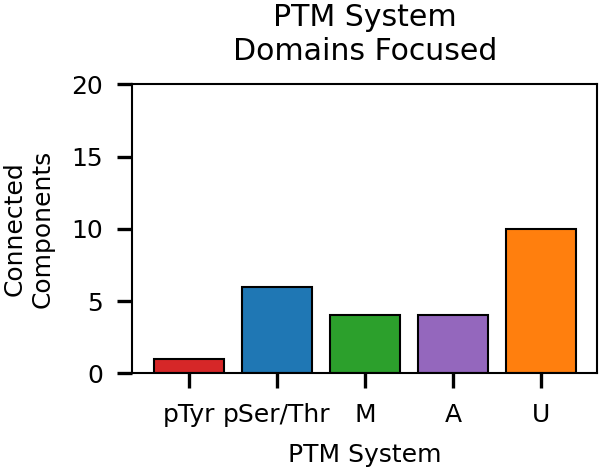

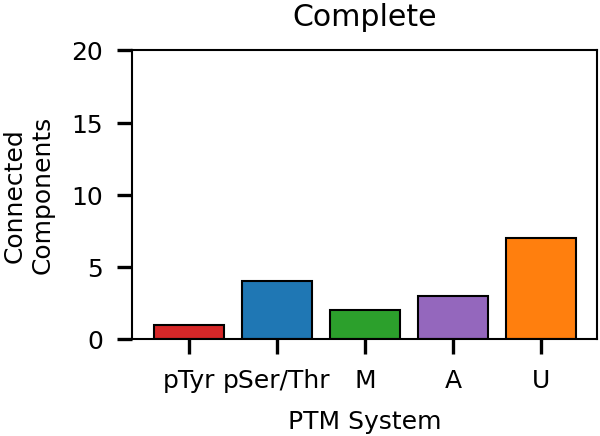

In [50]:
plt.figure(figsize=(2,1.25),dpi = 300, clear=True)
plt.bar(height =ptm_nNet_summary['CC'], x = ptm_nNet_summary.index,color=['tab:red','tab:blue','tab:green','tab:purple','tab:orange','gray'],edgecolor = 'k',linewidth=0.5)
plt.yticks(ticks=np.arange(0,21,5))
plt.xlabel('PTM System')
plt.title('PTM System\nDomains Focused')
plt.ylabel('Connected\nComponents')
#plt.title('PTM System Domains Focused')
plt.savefig('Figures/Manuscript Figures/Figure 4 PTM System Analysis/PTM Systems Domain Focused Connected Components.svg', transparent=True)

plt.figure(figsize=(2,1.25),dpi = 300, clear=True)
plt.bar(height =ptm_nNet_summary['CC Full'].tolist(), x = ptm_nNet_summary.index,color=['tab:red','tab:blue','tab:green','tab:purple','tab:orange','gray'],edgecolor = 'k',linewidth=0.5)
plt.yticks(ticks=np.arange(0,21,5))
plt.ylabel('Connected\nComponents')
plt.xlabel('PTM System')
plt.title('Complete')
plt.savefig('Figures/Manuscript Figures/Figure 4 PTM System Analysis/PTM Systems All Domains Connected Components.svg', transparent=True)

In [47]:
ptm_nNet_summary

,CC,Isolates,CC Full,Isolates Full,Relative Entropy
pTyr,1,0,1,0,0.343763
pSer/Thr,6,2,4,2,0.183614
M,4,1,2,1,0.274787
A,4,1,3,1,0.281667
U,10,2,7,3,0.393354
All,NaN,NaN,NaN,NaN,NaN


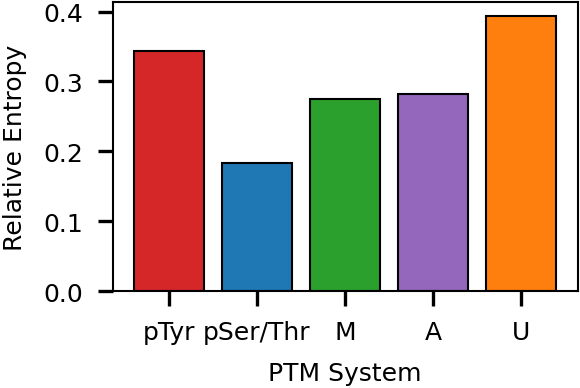

In [48]:
plt.figure(figsize=(2,1.25),dpi=300)
plt.bar(height =ptm_nNet_summary['Relative Entropy'].tolist(), x = ptm_nNet_summary.index,color=['tab:red','tab:blue','tab:green','tab:purple','tab:orange','gray'],edgecolor = 'k',linewidth=0.5)
#plt.yticks(ticks=np.arange(0,21,5))
plt.ylabel('Relative Entropy')
plt.xlabel('PTM System')
plt.savefig('Figures/Manuscript Figures/Figure 4 PTM System Analysis/PTM Systems Relative Entropy.svg', transparent=True)